Scanning for data in '../output'...
  > Loaded data for: ppo_42
  > Loaded data for: dqn_vanilla_126
  > Loaded data for: dqn_enhanced_126
  > Loaded data for: dqn_enhanced_84
  > Loaded data for: dqn_vanilla_84
  > Loaded data for: ppo_84
  > Loaded data for: ppo_126
  > Loaded data for: dqn_enhanced_42
  > Loaded data for: dqn_vanilla_42

Generating Plot 1: DQN Ablation Study...


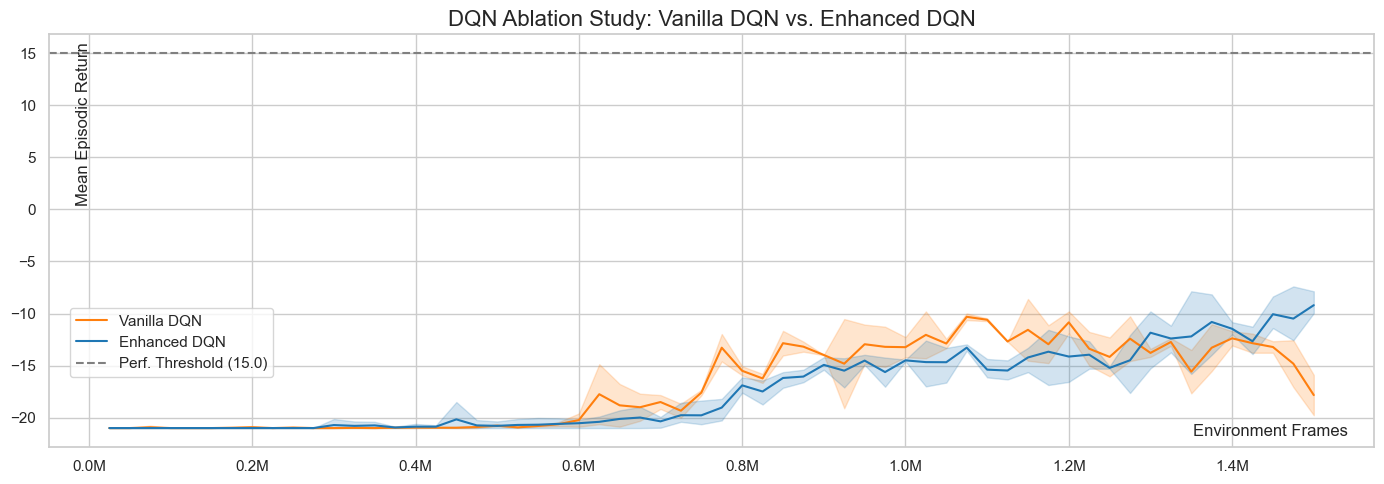


Generating Plot 2: Enhanced DQN vs. PPO...


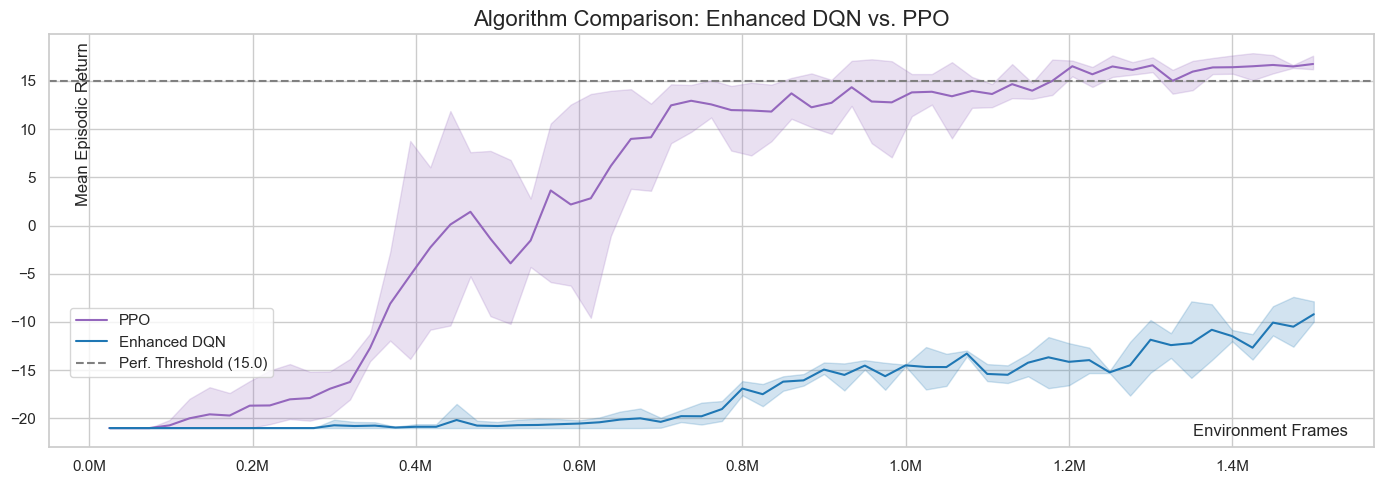

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# --- 1. Data Loading and Preparation ---
# This section defines a function to systematically find and load all experimental results.

def load_experiment_data(base_dir='../output'):
    """
    Scans the specified directory for experiment run folders, each identified by
    a naming convention like 'agent-name_seed' (e.g., 'dqn_vanilla_42').
    It loads the 'metrics.csv' file from each run, extracts the agent name
    and seed, and aggregates all data into a single, unified pandas DataFrame.

    Args:
        base_dir (str): The path to the root directory containing the output folders.

    Returns:
        pandas.DataFrame: A DataFrame containing the combined data from all seeds
                          and agents, with added 'agent_name' and 'seed' columns.
                          Returns an empty DataFrame if no data is found.
    """
    all_dfs = []
    print(f"Scanning for data in '{base_dir}'...")

    if not os.path.isdir(base_dir):
        print(f"Error: Directory '{base_dir}' not found. Please ensure the path is correct.")
        return pd.DataFrame()

    for run_name in os.listdir(base_dir):
        # We only process directories that match our expected naming convention.
        if not run_name.startswith(('dqn_vanilla_', 'dqn_enhanced_', 'ppo_')):
            continue
            
        results_dir = os.path.join(base_dir, run_name, 'results')
        metrics_file = os.path.join(results_dir, 'metrics.csv')

        if os.path.exists(metrics_file):
            try:
                # Parse agent name and seed from the folder name.
                parts = run_name.rsplit('_', 1)
                agent_name, seed = (parts[0], int(parts[1])) if len(parts) == 2 and parts[1].isdigit() else (run_name, 0)

                df = pd.read_csv(metrics_file)
                df['agent_name'] = agent_name
                df['seed'] = seed
                all_dfs.append(df)
                print(f"  > Loaded data for: {run_name}")
            except Exception as e:
                print(f"Could not load or parse {metrics_file}: {e}")
    
    if not all_dfs:
        print("Warning: No data loaded. Could not find any 'metrics.csv' files.")
        return pd.DataFrame()
        
    # Combine the list of DataFrames into one and clean it.
    full_df = pd.concat(all_dfs, ignore_index=True)
    full_df.dropna(subset=['eval_mean_return'], inplace=True)
    
    return full_df

# --- 2. Main Script Logic and Configuration ---
# This section executes the data loading and sets up parameters for plotting.

# Load all experiment data using the function defined above.
full_df = load_experiment_data()

if not full_df.empty:
    # --- User-configurable Plotting Parameters ---
    plot_width = 14
    plot_height = 6
    # This value controls the vertical offset of the legend from the bottom of the plot.
    # A value of 0.05 is 5% up from the bottom edge. Adjust as needed.
    # 0.15 would be ~100px on a standard plot.
    legend_y_offset = 0.15 

    # Mappings for consistent naming and coloring in the plots.
    agent_display_map = {
        'dqn_vanilla': 'Vanilla DQN',
        'dqn_enhanced': 'Enhanced DQN',
        'ppo': 'PPO'
    }
    color_palette_map = {
        'Vanilla DQN': '#ff7f0e',  # Orange
        'Enhanced DQN': '#1f77b4', # Blue
        'PPO': '#9467bd'           # Purple
    }

    # Add a new 'Agent' column with the pretty names for plot legends.
    full_df['Agent'] = full_df['agent_name'].map(agent_display_map)

    # --- 3. Plot Generation ---
    # This section generates the two required comparison charts.
    
    sns.set_theme(style="whitegrid")
    
    # This helper function formats large numbers on the x-axis (e.g., 500000 -> "0.5M").
    def millions_formatter(x, pos):
        return f'{x / 1_000_000:.1f}M'

    # === Plot 1: DQN Ablation Study ===
    print("\nGenerating Plot 1: DQN Ablation Study...")
    plt.figure(figsize=(plot_width, plot_height))
    
    # Filter the DataFrame to include only the DQN agents for this comparison.
    dqn_df = full_df[full_df['agent_name'].isin(['dqn_vanilla', 'dqn_enhanced'])]
    
    # Generate the line plot. Seaborn automatically calculates the mean across seeds.
    # The 'errorbar=('ci', 95)' parameter creates the 95% confidence interval shading.
    ax1 = sns.lineplot(
        data=dqn_df,
        x='environment_frame',
        y='eval_mean_return',
        hue='Agent',
        palette={'Vanilla DQN': color_palette_map['Vanilla DQN'], 'Enhanced DQN': color_palette_map['Enhanced DQN']},
        errorbar=('ci', 95)
    )

    # Add a horizontal dashed line to indicate the performance threshold.
    ax1.axhline(15.0, ls='--', color='0.5', label='Perf. Threshold (15.0)')
    
    # Remove default axis labels to replace them with custom-positioned text.
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    
    # Add axis labels inside the plot area for a cleaner, more modern look.
    ax1.text(0.98, 0.02, 'Environment Frames', transform=ax1.transAxes, ha='right', va='bottom', fontsize=12)
    ax1.text(0.02, 0.98, 'Mean Episodic Return', transform=ax1.transAxes, ha='left', va='top', fontsize=12, rotation=90)
    
    # Apply the custom formatter to the x-axis ticks.
    ax1.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
    
    ax1.set_title('DQN Ablation Study: Vanilla DQN vs. Enhanced DQN', fontsize=16)
    
    # Position the legend in the bottom-left, using the configurable offset.
    ax1.legend(loc='lower left', bbox_to_anchor=(0.01, legend_y_offset))
    plt.tight_layout()
    plt.show()

    # === Plot 2: Enhanced DQN vs. PPO ===
    print("\nGenerating Plot 2: Enhanced DQN vs. PPO...")
    plt.figure(figsize=(plot_width, plot_height))

    # Filter for the agents relevant to this comparison.
    compare_df = full_df[full_df['agent_name'].isin(['dqn_enhanced', 'ppo'])]

    ax2 = sns.lineplot(
        data=compare_df,
        x='environment_frame',
        y='eval_mean_return',
        hue='Agent',
        palette={'Enhanced DQN': color_palette_map['Enhanced DQN'], 'PPO': color_palette_map['PPO']},
        errorbar=('ci', 95)
    )

    ax2.axhline(15.0, ls='--', color='0.5', label='Perf. Threshold (15.0)')
    
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    
    ax2.text(0.98, 0.02, 'Environment Frames', transform=ax2.transAxes, ha='right', va='bottom', fontsize=12)
    ax2.text(0.02, 0.98, 'Mean Episodic Return', transform=ax2.transAxes, ha='left', va='top', fontsize=12, rotation=90)
    
    ax2.xaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
             
    ax2.set_title('Algorithm Comparison: Enhanced DQN vs. PPO', fontsize=16)
    
    # Position the legend in the bottom-left, using the same configurable offset.
    ax2.legend(loc='lower left', bbox_to_anchor=(0.01, legend_y_offset))
    plt.tight_layout()
    plt.show()